In [1]:
# Import Libraries
import os
import re
import cv2
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    roc_auc_score,
    f1_score
)
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

# Define constants
IMG_TARGET_SIZE = (224, 224)  # Ukuran gambar input untuk DenseNet121
BATCH_SIZE = 32  # Ukuran batch untuk pelatihan
EPOCHS = 25  # Jumlah epoch untuk pelatihan
LEARNING_RATE = 0.0001

2025-08-14 06:48:40.761162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755154120.949466      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755154121.001987      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import pandas as pd

# Directories for segmentation dataset
seg_dataset_path = '/kaggle/input/chest-x-ray-lungs-segmentation'
seg_images_path = os.path.join(seg_dataset_path, 'Chest-X-Ray', 'Chest-X-Ray', 'image')
seg_masks_path = os.path.join(seg_dataset_path, 'Chest-X-Ray', 'Chest-X-Ray', 'mask')

# Directories for classification dataset
cls_dataset_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
cls_normal_path = os.path.join(cls_dataset_path, 'Normal')
cls_tb_path = os.path.join(cls_dataset_path, 'Tuberculosis')

# Count files for segmentation
seg_image_count = len(os.listdir(seg_images_path))
seg_mask_count = len(os.listdir(seg_masks_path))
seg_total_count = seg_image_count + seg_mask_count

# Count files for classification
cls_normal_count = len(os.listdir(cls_normal_path))
cls_tb_count = len(os.listdir(cls_tb_path))
cls_total_count = cls_normal_count + cls_tb_count

# Print counts
print("Segmentation - Image Count:", seg_image_count)
print("Segmentation - Mask Count:", seg_mask_count)
print("Segmentation - Total Files:", seg_total_count)
print("Classification - Normal Images:", cls_normal_count)
print("Classification - Tuberculosis Images:", cls_tb_count)
print("Classification - Total Images:", cls_total_count)

# Read segmentation metadata (if available)
seg_metadata_file = os.path.join(seg_dataset_path, 'MetaData.csv')
seg_metadata_df = pd.read_csv(seg_metadata_file) if os.path.exists(seg_metadata_file) else pd.DataFrame()

# Read classification metadata
cls_metadata_normal = pd.read_excel(os.path.join(cls_dataset_path, 'Normal.metadata.xlsx'))
cls_metadata_tb = pd.read_excel(os.path.join(cls_dataset_path, 'Tuberculosis.metadata.xlsx'))

# Combine classification metadata into one DataFrame
cls_metadata_df = pd.concat([
    cls_metadata_normal.assign(label=0), 
    cls_metadata_tb.assign(label=1)
], ignore_index=True)

# Display segmentation metadata
print("\nSegmentation Metadata - First 5 Rows:")
print(seg_metadata_df.head() if not seg_metadata_df.empty else "No segmentation metadata available")
print("\nSegmentation Metadata - Info:")
print(seg_metadata_df.info() if not seg_metadata_df.empty else "No segmentation metadata available")
print("\nSegmentation Metadata - Descriptive Stats:")
print(seg_metadata_df.describe())

# Display classification metadata
print("\nClassification Metadata - First 5 Rows:")
print(cls_metadata_df.head())
print("\nClassification Metadata - Info:")
print(cls_metadata_df.info())
print("\nClassification Metadata - Descriptive Stats:")
print(cls_metadata_df.describe())

Segmentation - Image Count: 704
Segmentation - Mask Count: 704
Segmentation - Total Files: 1408
Classification - Normal Images: 3500
Classification - Tuberculosis Images: 700
Classification - Total Images: 4200

Segmentation Metadata - First 5 Rows:
     id gender age    county  ptb                                      remarks
0  1000   male  31  Shenxhen    0                                       normal
1  1001   male  64  Shenxhen    0                                       normal
2  1002   male  35  Shenxhen    0                                       normal
3  1003   male  32  Shenxhen    1               STB,ATB,tuberculosis pleuritis
4  1004   male   2  Shenxhen    1  secondary PTB  in the bilateral upper field

Segmentation Metadata - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       704 non-null    int64 
 1   gender   704 non-null    

Sample Segmentation Images and Masks:


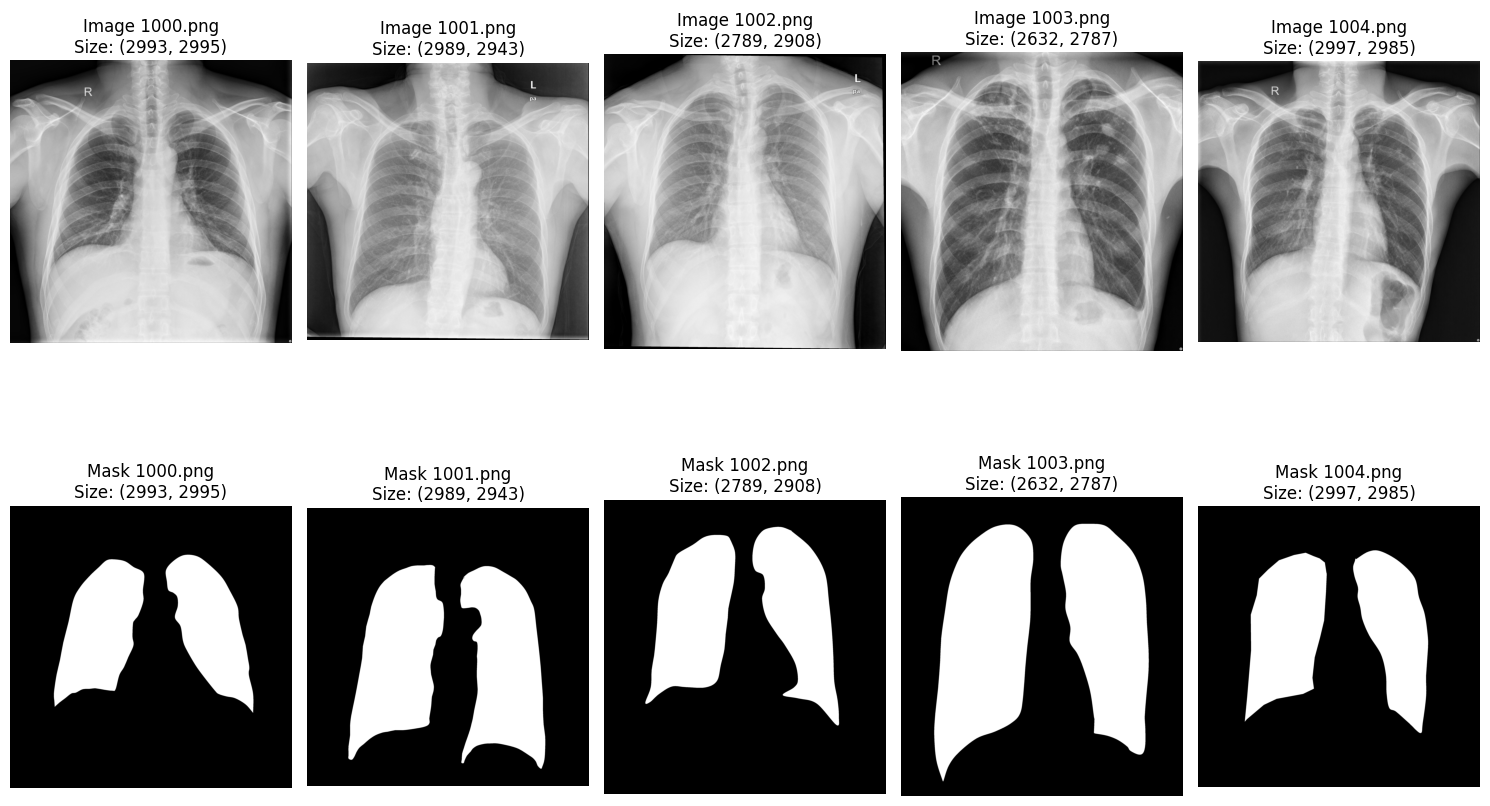


Count per 'ptb' label in segmentation metadata:
ptb
0    359
1    345
Name: count, dtype: int64


Validating Image-Mask Pairs: 100%|██████████| 704/704 [00:08<00:00, 83.50it/s]


Number of valid image-mask pairs: 704


Resizing & Normalizing: 100%|██████████| 704/704 [02:09<00:00,  5.45it/s]



Preprocessed Samples:


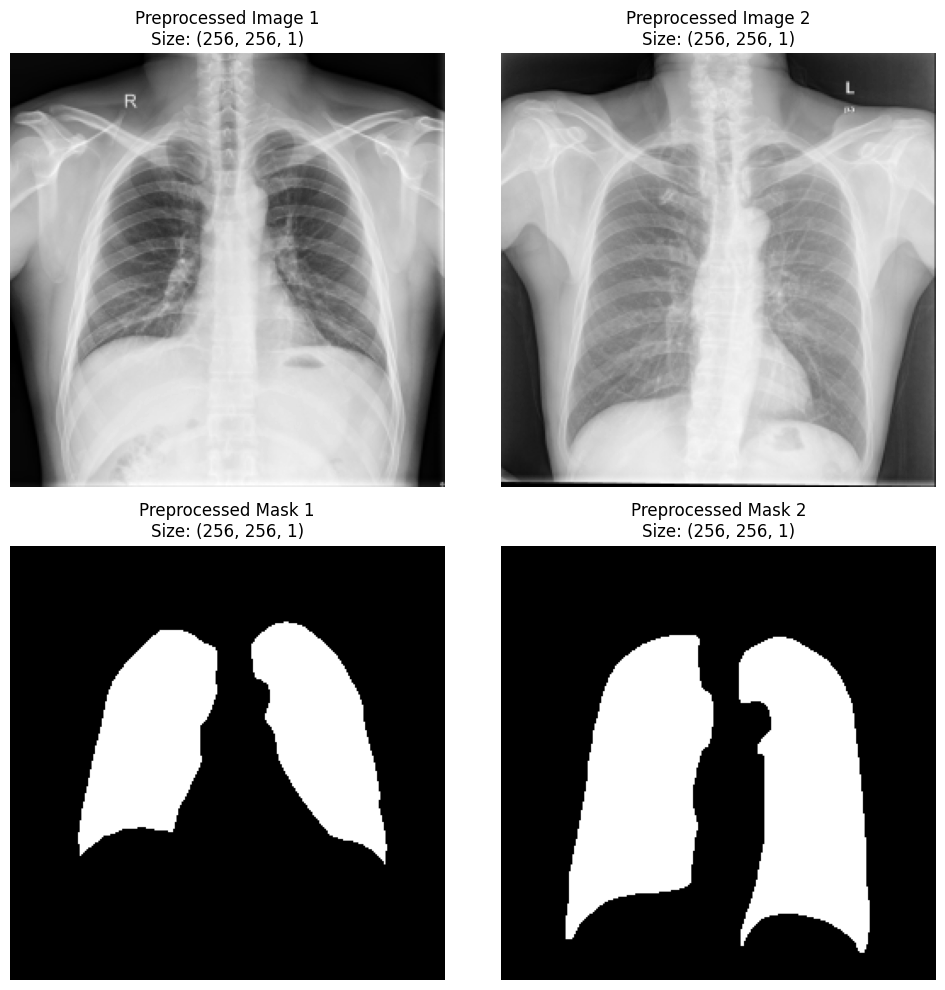

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

# List image and mask files
seg_image_files = sorted(os.listdir(seg_images_path))
seg_mask_files = sorted(os.listdir(seg_masks_path))

# Function to display sample images and masks in two rows
def display_segmentation_samples(image_files, mask_files, img_dir, mask_dir, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    # First row: original images
    for i in range(min(num_samples, len(image_files))):
        img_path = os.path.join(img_dir, image_files[i])
        img = Image.open(img_path)
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image {image_files[i]}\nSize: {img.size}")
        plt.axis('off')
    
    # Second row: corresponding masks
    for i in range(min(num_samples, len(mask_files))):
        mask_path = os.path.join(mask_dir, mask_files[i])
        mask = Image.open(mask_path)
        plt.subplot(2, num_samples, i+1 + num_samples)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {mask_files[i]}\nSize: {mask.size}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images and masks
print("Sample Segmentation Images and Masks:")
display_segmentation_samples(seg_image_files, seg_mask_files, seg_images_path, seg_masks_path)

# Data exploration: segmentation metadata statistics
print("\nCount per 'ptb' label in segmentation metadata:")
print(seg_metadata_df['ptb'].value_counts())

# Function to clean and validate image-mask pairs
def validate_image_mask_pairs(image_files, mask_files, img_dir, mask_dir):
    valid_pairs = []
    for img_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Validating Image-Mask Pairs"):
        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        try:
            with Image.open(img_path) as img, Image.open(mask_path) as mask:
                if img.size == mask.size and img.size[0] > 0 and img.size[1] > 0:
                    valid_pairs.append((img_file, mask_file))
        except Exception as e:
            print(f"Error loading {img_file} or {mask_file}: {e}")
    return valid_pairs

# Clean dataset
valid_pairs = validate_image_mask_pairs(seg_image_files, seg_mask_files, seg_images_path, seg_masks_path)
seg_image_files, seg_mask_files = zip(*valid_pairs)
print("Number of valid image-mask pairs:", len(seg_image_files))

# Function for preprocessing (resize + normalize)
def preprocess_segmentation_data(image_files, mask_files, img_dir, mask_dir, target_size=(256, 256)):
    processed_images = []
    processed_masks = []
    for img_file, mask_file in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Resizing & Normalizing"):
        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        # Read in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        
        # Normalize to 0–1 range
        img_normalized = img_resized / 255.0
        mask_normalized = mask_resized / 255.0
        
        processed_images.append(img_normalized)
        processed_masks.append(mask_normalized)
    
    return np.array(processed_images), np.array(processed_masks)

# Run preprocessing
IMG_TARGET_SIZE = (256, 256)
images_preprocessed, masks_preprocessed = preprocess_segmentation_data(
    seg_image_files, seg_mask_files, seg_images_path, seg_masks_path, IMG_TARGET_SIZE
)

# Ensure correct channel dimensions
if len(images_preprocessed.shape) == 3:
    images_preprocessed = np.expand_dims(images_preprocessed, axis=-1)
    masks_preprocessed = np.expand_dims(masks_preprocessed, axis=-1)

images_preprocessed = images_preprocessed.astype('float32')
masks_preprocessed = masks_preprocessed.astype('float32')

# Show examples after preprocessing
print("\nPreprocessed Samples:")
plt.figure(figsize=(10, 10))
for i in range(2):
    # Row 1: preprocessed image
    plt.subplot(2, 2, i+1)
    plt.imshow(images_preprocessed[i], cmap='gray')
    plt.title(f"Preprocessed Image {i+1}\nSize: {images_preprocessed[i].shape}")
    plt.axis('off')
    
    # Row 2: preprocessed mask
    plt.subplot(2, 2, i+1 + 2)
    plt.imshow(masks_preprocessed[i], cmap='gray')
    plt.title(f"Preprocessed Mask {i+1}\nSize: {masks_preprocessed[i].shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Dataset split completed.


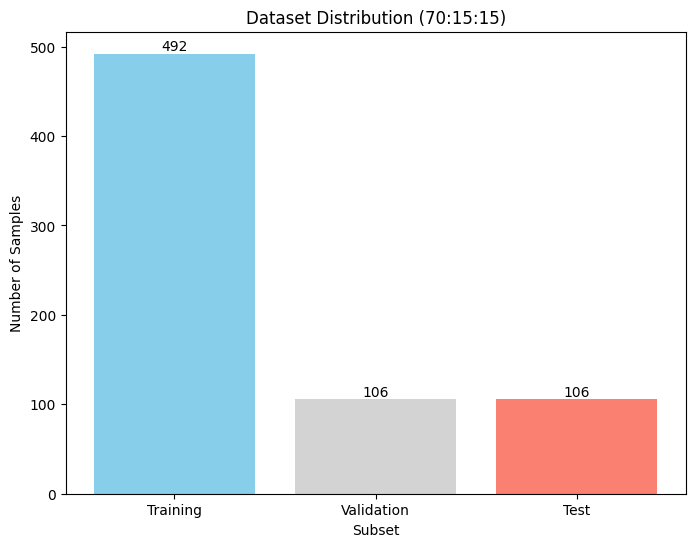

Sample images from each dataset subset:


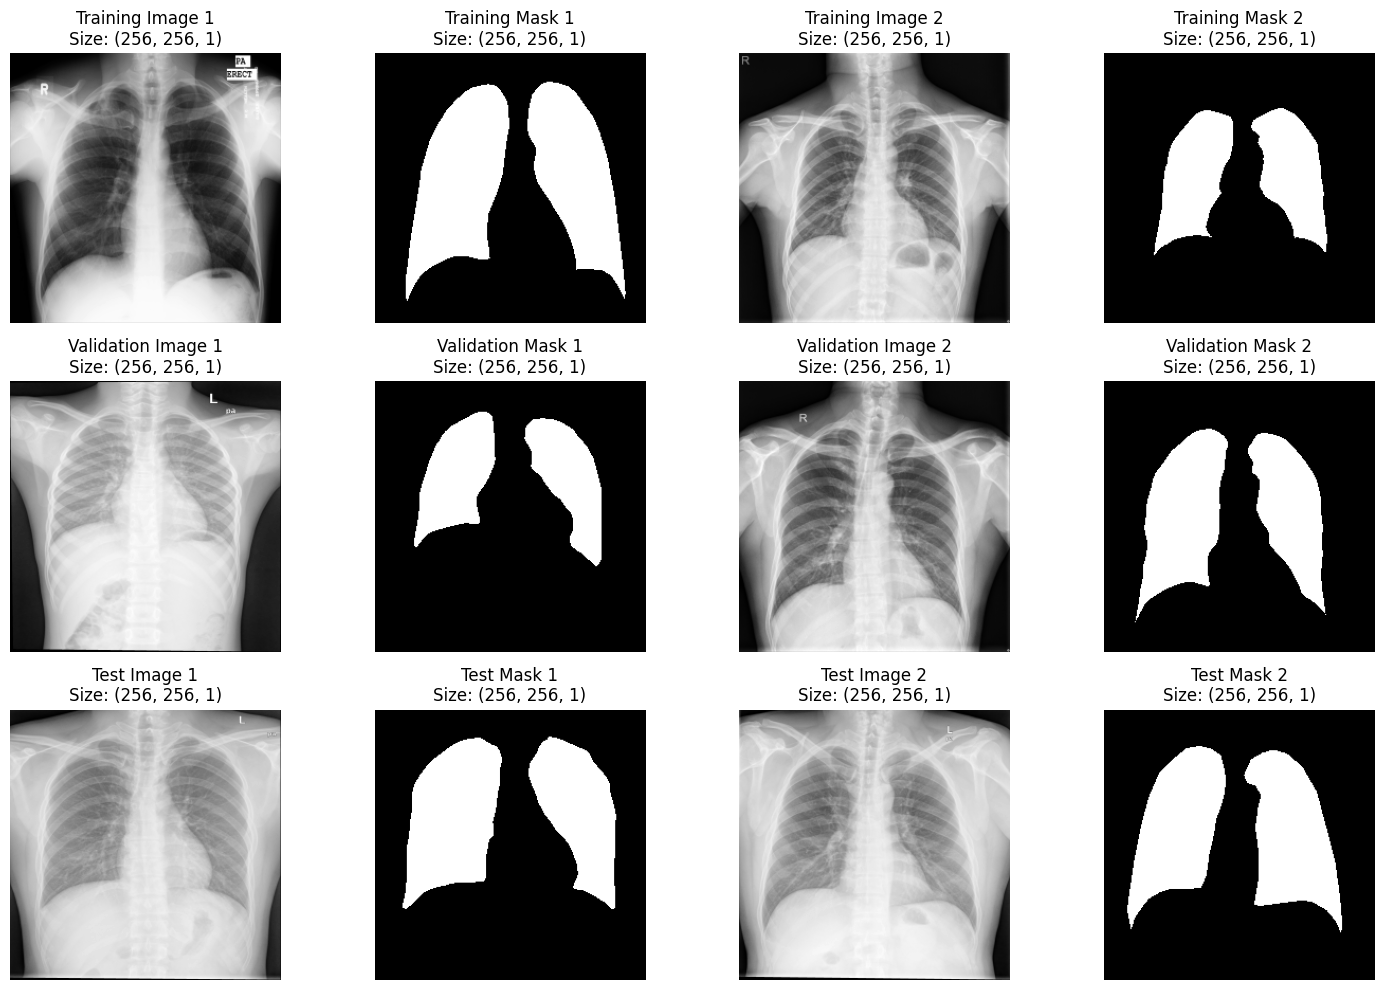

In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to split data into Train/Validation/Test sets (70:15:15)
def split_dataset(images, masks, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    # First split: Train set and the remaining data
    X_train, X_temp, y_train, y_temp = train_test_split(
        images, masks, train_size=train_ratio, random_state=random_state
    )
    
    # Second split: Validation and Test from remaining data
    val_test_ratio = val_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, train_size=val_test_ratio, random_state=random_state
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Perform the split
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(images_preprocessed, masks_preprocessed)
print("Dataset split completed.")

# Visualize label distribution with bar chart
subset_labels = ['Training', 'Validation', 'Test']
subset_sizes = [len(X_train), len(X_val), len(X_test)]
subset_colors = ['skyblue', 'lightgrey', 'salmon']  # Distinct colors for visibility

plt.figure(figsize=(8, 6))
bars = plt.bar(subset_labels, subset_sizes, color=subset_colors)
plt.title('Dataset Distribution (70:15:15)')
plt.xlabel('Subset')
plt.ylabel('Number of Samples')

# Add data labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, int(height), ha='center', va='bottom')
plt.show()

# Function to display example images & masks from each subset
def display_dataset_examples(X_train, X_val, X_test, y_train, y_val, y_test, num_samples=2):
    plt.figure(figsize=(15, 10))
    subsets = [
        (X_train, y_train, 'Training'),
        (X_val, y_val, 'Validation'),
        (X_test, y_test, 'Test')
    ]
    
    for i, (X_subset, y_subset, title) in enumerate(subsets):
        for j in range(min(num_samples, len(X_subset))):
            # Display image
            plt.subplot(len(subsets), num_samples * 2, j * 2 + 1 + i * num_samples * 2)
            plt.imshow(X_subset[j], cmap='gray')
            plt.title(f"{title} Image {j+1}\nSize: {X_subset[j].shape}")
            plt.axis('off')
            
            # Display mask
            plt.subplot(len(subsets), num_samples * 2, j * 2 + 2 + i * num_samples * 2)
            plt.imshow(y_subset[j], cmap='gray')
            plt.title(f"{title} Mask {j+1}\nSize: {y_subset[j].shape}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample images from each dataset subset:")
display_dataset_examples(X_train, X_val, X_test, y_train, y_val, y_test)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_unet(input_shape=(224, 224, 1)):
    inputs = layers.Input(input_shape)
    
    # -------- Encoder --------
    # Block 1
    conv1 = layers.Conv2D(64, 3, padding='same')(inputs)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.Conv2D(64, 3, padding='same')(conv1)
    conv1 = layers.ReLU()(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(0.25)(pool1)
    
    # Block 2
    conv2 = layers.Conv2D(128, 3, padding='same')(pool1)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.Conv2D(128, 3, padding='same')(conv2)
    conv2 = layers.ReLU()(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(0.25)(pool2)
    
    # Block 3
    conv3 = layers.Conv2D(256, 3, padding='same')(pool2)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.Conv2D(256, 3, padding='same')(conv3)
    conv3 = layers.ReLU()(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(0.25)(pool3)
    
    # Block 4
    conv4 = layers.Conv2D(512, 3, padding='same')(pool3)
    conv4 = layers.ReLU()(conv4)
    conv4 = layers.Conv2D(512, 3, padding='same')(conv4)
    conv4 = layers.ReLU()(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(0.25)(pool4)
    
    # -------- Bottleneck --------
    conv5 = layers.Conv2D(1024, 3, padding='same')(pool4)
    conv5 = layers.ReLU()(conv5)
    conv5 = layers.Conv2D(1024, 3, padding='same')(conv5)
    conv5 = layers.ReLU()(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    
    # -------- Decoder --------
    # Block 1
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, 3, padding='same')(up6)
    conv6 = layers.ReLU()(conv6)
    conv6 = layers.Conv2D(512, 3, padding='same')(conv6)
    conv6 = layers.ReLU()(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Dropout(0.25)(conv6)
    
    # Block 2
    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, 3, padding='same')(up7)
    conv7 = layers.ReLU()(conv7)
    conv7 = layers.Conv2D(256, 3, padding='same')(conv7)
    conv7 = layers.ReLU()(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Dropout(0.25)(conv7)
    
    # Block 3
    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, 3, padding='same')(up8)
    conv8 = layers.ReLU()(conv8)
    conv8 = layers.Conv2D(128, 3, padding='same')(conv8)
    conv8 = layers.ReLU()(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Dropout(0.25)(conv8)
    
    # Block 4
    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, 3, padding='same')(up9)
    conv9 = layers.ReLU()(conv9)
    conv9 = layers.Conv2D(64, 3, padding='same')(conv9)
    conv9 = layers.ReLU()(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Dropout(0.25)(conv9)
    
    # Output Layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile model
unet_model = build_unet()
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("U-Net model built and compiled successfully.")

I0000 00:00:1755154414.427679      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


U-Net model built and compiled successfully.



Fold 1/3
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1755154455.287506     101 service.cc:148] XLA service 0x7f2b04002340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755154455.288266     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755154456.708134     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1755154460.647201     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755154460.903451     101 gpu_timer.cc:

  1/118 ━━━━━━━━━━━━━━━━━━━━ 1:11:14 37s/step - accuracy: 0.4832 - dice_coefficient: 0.3382 - loss: 0.9050

I0000 00:00:1755154478.051470     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7858 - dice_coefficient: 0.5969 - loss: 0.4705

E0000 00:00:1755154533.296955     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755154533.531592     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755154534.271484     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755154534.529614     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


118/118 ━━━━━━━━━━━━━━━━━━━━ 99s 537ms/step - accuracy: 0.7866 - dice_coefficient: 0.5976 - loss: 0.4693 - val_accuracy: 0.7433 - val_dice_coefficient: 0.2887 - val_loss: 0.5409
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9343 - dice_coefficient: 0.7807 - loss: 0.1927 - val_accuracy: 0.5381 - val_dice_coefficient: 0.5155 - val_loss: 1.5453
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9396 - dice_coefficient: 0.8066 - loss: 0.1637 - val_accuracy: 0.4800 - val_dice_coefficient: 0.4846 - val_loss: 4.8329
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9405 - dice_coefficient: 0.8186 - loss: 0.1567 - val_accuracy: 0.8076 - val_dice_coefficient: 0.6244 - val_loss: 0.9748
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9407 - dice_coefficient: 0.8216 - loss: 0.1524 - val_accuracy: 0.8650 - val_dice_coefficient: 0.6985 - val_loss: 0.5726
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy:

E0000 00:00:1755155438.314880     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755155438.549403     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755155439.281988     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755155439.539513     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


118/118 ━━━━━━━━━━━━━━━━━━━━ 69s 370ms/step - accuracy: 0.8067 - dice_coefficient: 0.6103 - loss: 0.4577 - val_accuracy: 0.7472 - val_dice_coefficient: 0.2040 - val_loss: 0.5985
Epoch 2/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9315 - dice_coefficient: 0.7922 - loss: 0.1814 - val_accuracy: 0.7472 - val_dice_coefficient: 0.0912 - val_loss: 0.7813
Epoch 3/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9375 - dice_coefficient: 0.8145 - loss: 0.1589 - val_accuracy: 0.7357 - val_dice_coefficient: 0.1893 - val_loss: 0.6378
Epoch 4/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9390 - dice_coefficient: 0.8200 - loss: 0.1534 - val_accuracy: 0.7701 - val_dice_coefficient: 0.4666 - val_loss: 0.5348
Epoch 5/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.9414 - dice_coefficient: 0.8285 - loss: 0.1454 - val_accuracy: 0.8832 - val_dice_coefficient: 0.6922 - val_loss: 0.3338
Epoch 6/25
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy:

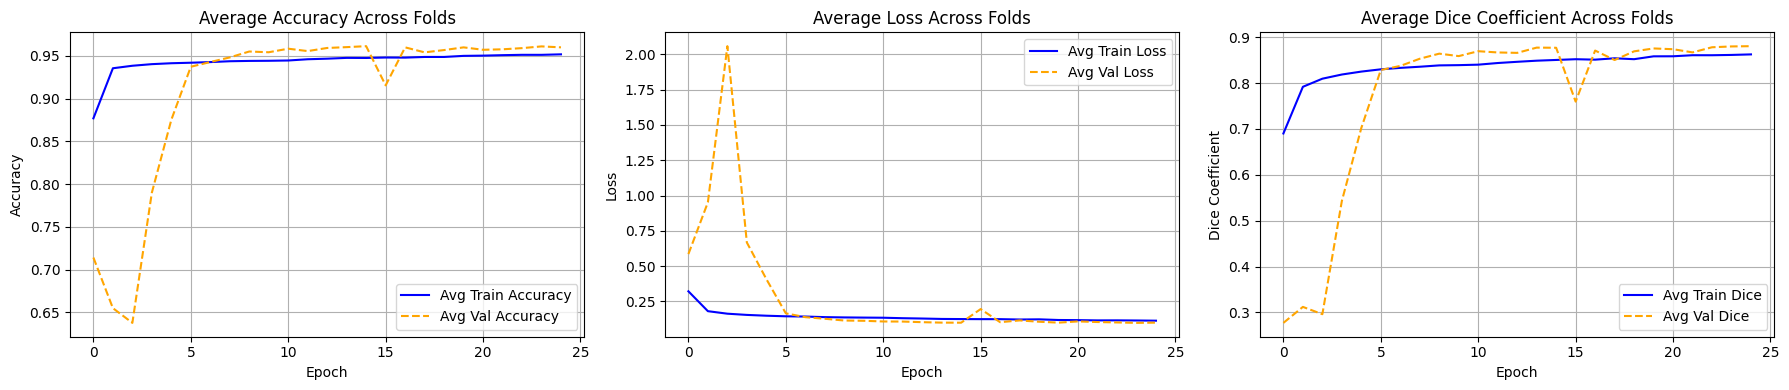

In [6]:
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dice Coefficient Metric
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-7)

# Data augmentation for segmentation
datagenSeg = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # Set to True if horizontal flipping is acceptable
    fill_mode='nearest'
)
datagenSeg.fit(images_preprocessed)

# 3-Fold Cross-Validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
fold_results = []
best_val_acc = -1
best_fold = -1
all_histories = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(images_preprocessed, masks_preprocessed)):
    print(f'\nFold {fold + 1}/3')

    # Split train/validation for this fold
    X_train, X_val = images_preprocessed[train_idx], images_preprocessed[val_idx]
    y_train, y_val = masks_preprocessed[train_idx], masks_preprocessed[val_idx]
    
    # Build a fresh U-Net model for each fold
    model = build_unet(input_shape=(256, 256, 1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', dice_coefficient]
    )
    
    # Train model
    history = model.fit(
        datagenSeg.flow(X_train, y_train, batch_size=4),
        validation_data=(X_val, y_val),
        epochs=25,
        verbose=1
    )
    
    # Evaluate on validation data
    val_loss, val_acc, val_dice = model.evaluate(X_val, y_val, verbose=0)
    fold_results.append({'fold': fold + 1, 'val_loss': val_loss, 'val_acc': val_acc, 'val_dice': val_dice})
    
    # Save model for this fold
    model.save(f'unet_model_fold_{fold + 1}.h5')
    
    # Track best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_fold = fold + 1
    
    all_histories.append(history.history)

# Final test split (15% of data)
_, X_test, _, y_test = train_test_split(
    images_preprocessed, masks_preprocessed, test_size=0.15, random_state=42
)

# Print results per fold
print("\n3-Fold cross-validation results:")
for result in fold_results:
    print(f"Fold {result['fold']}: Val Loss = {result['val_loss']:.4f}, Val Accuracy = {result['val_acc']:.4f}, Val Dice = {result['val_dice']:.4f}")

print(f"\nBest Fold: Fold {best_fold} with Val Accuracy = {best_val_acc:.4f}")

# Load best model
best_model = tf.keras.models.load_model(
    f'unet_model_fold_{best_fold}.h5',
    custom_objects={'dice_coefficient': dice_coefficient}
)
print(f"Loaded best model from unet_model_fold_{best_fold}.h5")

# Prepare average metrics across folds
min_epochs = min(len(h['accuracy']) for h in all_histories)
avg_accuracy = np.mean([h['accuracy'][:min_epochs] for h in all_histories], axis=0)
avg_val_accuracy = np.mean([h['val_accuracy'][:min_epochs] for h in all_histories], axis=0)
avg_loss = np.mean([h['loss'][:min_epochs] for h in all_histories], axis=0)
avg_val_loss = np.mean([h['val_loss'][:min_epochs] for h in all_histories], axis=0)
avg_dice = np.mean([h['dice_coefficient'][:min_epochs] for h in all_histories], axis=0)
avg_val_dice = np.mean([h['val_dice_coefficient'][:min_epochs] for h in all_histories], axis=0)

# Plot averaged metrics
plt.figure(figsize=(18, 4))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(avg_accuracy, label='Avg Train Accuracy', color='blue')
plt.plot(avg_val_accuracy, label='Avg Val Accuracy', color='orange', linestyle='--')
plt.title('Average Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(avg_loss, label='Avg Train Loss', color='blue')
plt.plot(avg_val_loss, label='Avg Val Loss', color='orange', linestyle='--')
plt.title('Average Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Dice plot
plt.subplot(1, 3, 3)
plt.plot(avg_dice, label='Avg Train Dice', color='blue')
plt.plot(avg_val_dice, label='Avg Val Dice', color='orange', linestyle='--')
plt.title('Average Dice Coefficient Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step
Test Loss: 0.0855, Test Accuracy: 0.9645, Test Dice Coefficient: 0.8893
Manually Computed Dice Coefficient: 0.9274
Confusion Matrix:
 [[5124657   79606]
 [ 167060 1575493]]


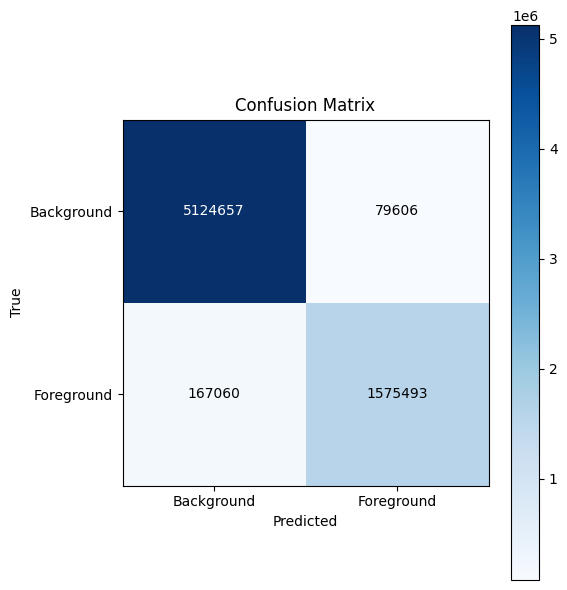

In [7]:
# === Evaluation on test data using the best model from CV ===

# Predict on test data
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)  # Binarize predictions

# Evaluate model (loss, accuracy, dice)
loss, accuracy, dice = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Dice Coefficient: {dice:.4f}")

# Manual Dice Coefficient (verification)
def manual_dice_coefficient(y_true, y_pred_bin):
    intersection = np.sum(y_true * y_pred_bin)
    return (2. * intersection + 1e-7) / (np.sum(y_true) + np.sum(y_pred_bin) + 1e-7)

dice_score_manual = manual_dice_coefficient(y_test, y_pred_binary)
print(f"Manually Computed Dice Coefficient: {dice_score_manual:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test.flatten(), y_pred_binary.flatten())
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Background', 'Foreground'])
plt.yticks([0, 1], ['Background', 'Foreground'])
plt.xlabel('Predicted')
plt.ylabel('True')

# Add text inside matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

In [8]:
# === Normalize File Names for Classification Dataset ===
def normalize_filename(fname):
    return re.sub(r'\s+', '-', fname.strip()).lower()

# Normalize file names in classification metadata
cls_metadata_df['FILE NAME NORMALIZED'] = cls_metadata_df['FILE NAME'].apply(normalize_filename)

# List all image files in directories (lowercase for matching)
all_files = {f.lower() for f in os.listdir(cls_normal_path) + os.listdir(cls_tb_path)}

# === Initial Checks ===

# 1. Missing Files
missing_files = cls_metadata_df[
    ~cls_metadata_df['FILE NAME NORMALIZED'].apply(lambda x: f"{x}.png" in all_files)
]['FILE NAME'].tolist()

if missing_files:
    print(f" Missing files: {missing_files[:10]}... (total {len(missing_files)})")
    cls_metadata_df = cls_metadata_df[
        cls_metadata_df['FILE NAME NORMALIZED'].apply(lambda x: f"{x}.png" in all_files)
    ]
    print(f"Entries after removing missing files: {len(cls_metadata_df)}")
else:
    print("✅ All image files are available.")

# 2. Null Values
null_counts = cls_metadata_df[['FILE NAME', 'label']].isnull().sum()
if null_counts.sum() > 0:
    print(" Null values found:", null_counts)
    cls_metadata_df = cls_metadata_df.dropna(subset=['FILE NAME', 'label'])
    print(f"Entries after removing null values: {len(cls_metadata_df)}")
else:
    print("✅ No null values.")

# 3. Duplicates
duplicates = cls_metadata_df[cls_metadata_df['FILE NAME'].duplicated(keep='first')]
if not duplicates.empty:
    print(f" Found {len(duplicates)} duplicates based on FILE NAME.")
    cls_metadata_df = cls_metadata_df.drop_duplicates(subset=['FILE NAME'], keep='first')
    print(f"Entries after removing duplicates: {len(cls_metadata_df)}")
else:
    print("✅ No duplicates.")

# 4. Filter Valid Labels
valid_labels = [0, 1]
cls_metadata_df = cls_metadata_df[cls_metadata_df['label'].isin(valid_labels)]
print(f"Unique 'label' values: {cls_metadata_df['label'].unique()}")
print(f"Entries after filtering valid labels: {len(cls_metadata_df)}")

# 5. Check Image Sizes & Corrupted Files
target_size = (512, 512)
inconsistent_sizes = []
corrupted_files = []

for fname in tqdm(cls_metadata_df['FILE NAME'], desc="Checking image size & integrity"):
    file_path_normal = os.path.join(cls_normal_path, f"{fname}.png")
    file_path_tb = os.path.join(cls_tb_path, f"{fname}.png")
    img_path = file_path_normal if os.path.exists(file_path_normal) else file_path_tb
    
    if os.path.exists(img_path):
        try:
            img = cv2.imread(img_path)
            if img is not None:
                if img.shape[:2] != target_size:
                    inconsistent_sizes.append((fname, img.shape[:2]))
            else:
                corrupted_files.append(fname)
        except Exception as e:
            corrupted_files.append(fname)
            print(f"Error loading {fname}: {str(e)}")

# Remove inconsistent size images
if inconsistent_sizes:
    print(f" {len(inconsistent_sizes)} images with inconsistent sizes.")
    for fname, size in inconsistent_sizes[:10]:
        print(f"File: {fname}, Size: {size}")
    cls_metadata_df = cls_metadata_df[
        ~cls_metadata_df['FILE NAME'].isin([f[0] for f in inconsistent_sizes])
    ]
    print(f"Entries after removing inconsistent size images: {len(cls_metadata_df)}")
else:
    print("✅ All images have consistent size:", target_size)

# Remove corrupted files
if corrupted_files:
    print(f"{len(corrupted_files)} corrupted images: {corrupted_files}")
    cls_metadata_df = cls_metadata_df[
        ~cls_metadata_df['FILE NAME'].isin(corrupted_files)
    ]
    print(f"Entries after removing corrupted images: {len(cls_metadata_df)}")
else:
    print("✅ No corrupted images.")

# 6. Check Filename Consistency with Directory
mismatched_files = [
    name for name in cls_metadata_df['FILE NAME NORMALIZED']
    if f"{name}.png" not in all_files
]
if mismatched_files:
    print(f" {len(mismatched_files)} mismatched file names: {mismatched_files[:10]}...")
    cls_metadata_df = cls_metadata_df[
        ~cls_metadata_df['FILE NAME NORMALIZED'].isin(mismatched_files)
    ]
    print(f"Entries after removing mismatched file names: {len(cls_metadata_df)}")
else:
    print("✅ All file names are consistent.")

# 7. Show Final Results
print("\nFirst 5 rows after normalization & cleaning:")
print(cls_metadata_df[['FILE NAME', 'FILE NAME NORMALIZED', 'label']].head())

✅ All image files are available.
✅ No null values.
✅ No duplicates.
Unique 'label' values: [0 1]
Entries after filtering valid labels: 4200


Checking image size & integrity: 100%|██████████| 4200/4200 [01:09<00:00, 60.51it/s]


✅ All images have consistent size: (512, 512)
✅ No corrupted images.
✅ All file names are consistent.

First 5 rows after normalization & cleaning:
  FILE NAME FILE NAME NORMALIZED  label
0  Normal-1             normal-1      0
1  Normal-2             normal-2      0
2  Normal-3             normal-3      0
3  Normal-4             normal-4      0
4  Normal-5             normal-5      0


Label distribution before balancing:
label
0    3500
1     700
Name: count, dtype: int64

Label distribution after balancing:
label
0    700
1    700
Name: count, dtype: int64
Total samples after balancing: 1400


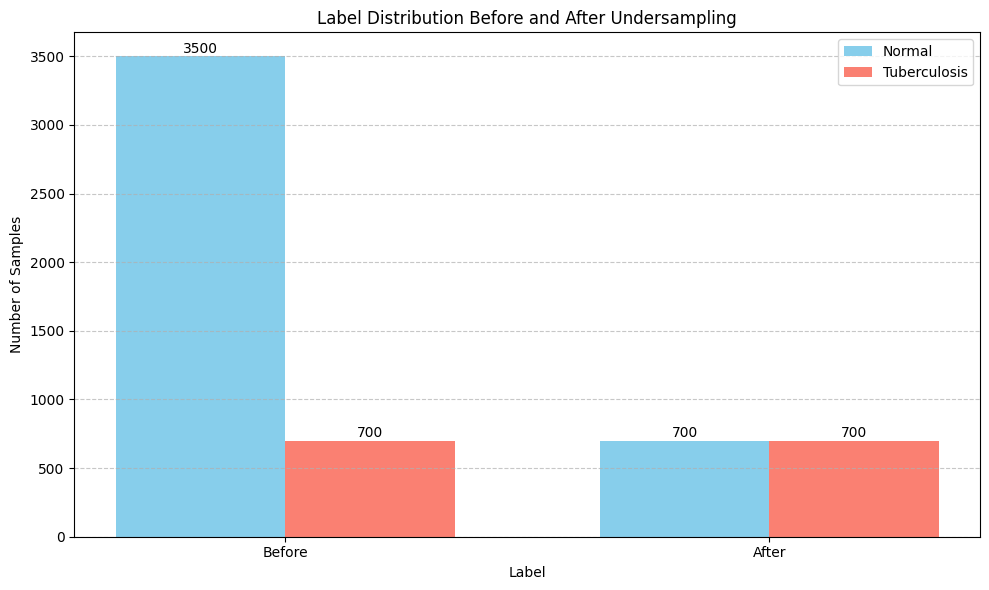

In [9]:
# === Dataset Balancing with Undersampling ===
print("Label distribution before balancing:")
print(cls_metadata_df['label'].value_counts())

# Target number of samples for each class
target_count = 700

# Take 700 random Normal samples
normal_samples = cls_metadata_df[cls_metadata_df['label'] == 0].sample(
    n=target_count, random_state=42
)

# Take all 700 Tuberculosis samples
tb_samples = cls_metadata_df[cls_metadata_df['label'] == 1]

# Combine into balanced dataset
cls_metadata_balanced = pd.concat([normal_samples, tb_samples]).reset_index(drop=True)

# Verify distribution after balancing
print("\nLabel distribution after balancing:")
print(cls_metadata_balanced['label'].value_counts())
print(f"Total samples after balancing: {len(cls_metadata_balanced)}")

# Optional: Save balanced dataset to CSV
cls_metadata_balanced.to_csv('balanced_metadata.csv', index=False)

# === Visualization ===
labels = ['Before', 'After']
before_counts = cls_metadata_df['label'].value_counts().sort_index().values
after_counts = cls_metadata_balanced['label'].value_counts().sort_index().values

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - width/2 for i in x], before_counts, width, label='Normal', color='skyblue')
plt.bar([i + width/2 for i in x], after_counts, width, label='Tuberculosis', color='salmon')

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Label Distribution Before and After Undersampling')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above bars
for i, v in enumerate(before_counts):
    plt.text(i - width/2, v + 5, str(v), ha='center', va='bottom')
for i, v in enumerate(after_counts):
    plt.text(i + width/2, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [17]:
# === Image Reading and Normalization ===
cleaned_images = []

for fname in tqdm(cls_metadata_balanced['FILE NAME'], desc="Processing images"):
    file_path_normal = os.path.join(cls_normal_path, f"{fname}.png")
    file_path_tb = os.path.join(cls_tb_path, f"{fname}.png")
    
    img_path = file_path_normal if os.path.exists(file_path_normal) else file_path_tb
    
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMG_TARGET_SIZE)  # Resize to target size
            img = img.astype(np.float32) / 255.0    # Normalize to [0, 1]
            cleaned_images.append(img)

# Convert list to NumPy array
cleaned_images = np.array(cleaned_images)

# Extract labels
labels = cls_metadata_balanced['label'].values

# Print info
print(f"Number of images successfully processed: {len(cleaned_images)}")
print(f"Shape of image array: {cleaned_images.shape}")
print(f"Shape of label array: {labels.shape}")

Processing images: 100%|██████████| 1400/1400 [00:13<00:00, 105.54it/s]


Number of images successfully processed: 1400
Shape of image array: (1400, 256, 256, 3)
Shape of label array: (1400,)


Segmentation Inference: 100%|██████████| 1400/1400 [02:02<00:00, 11.40it/s]


Segmentation inference completed. Mask array shape: (1400, 256, 256)
3 Samples from Segmentation Inference:


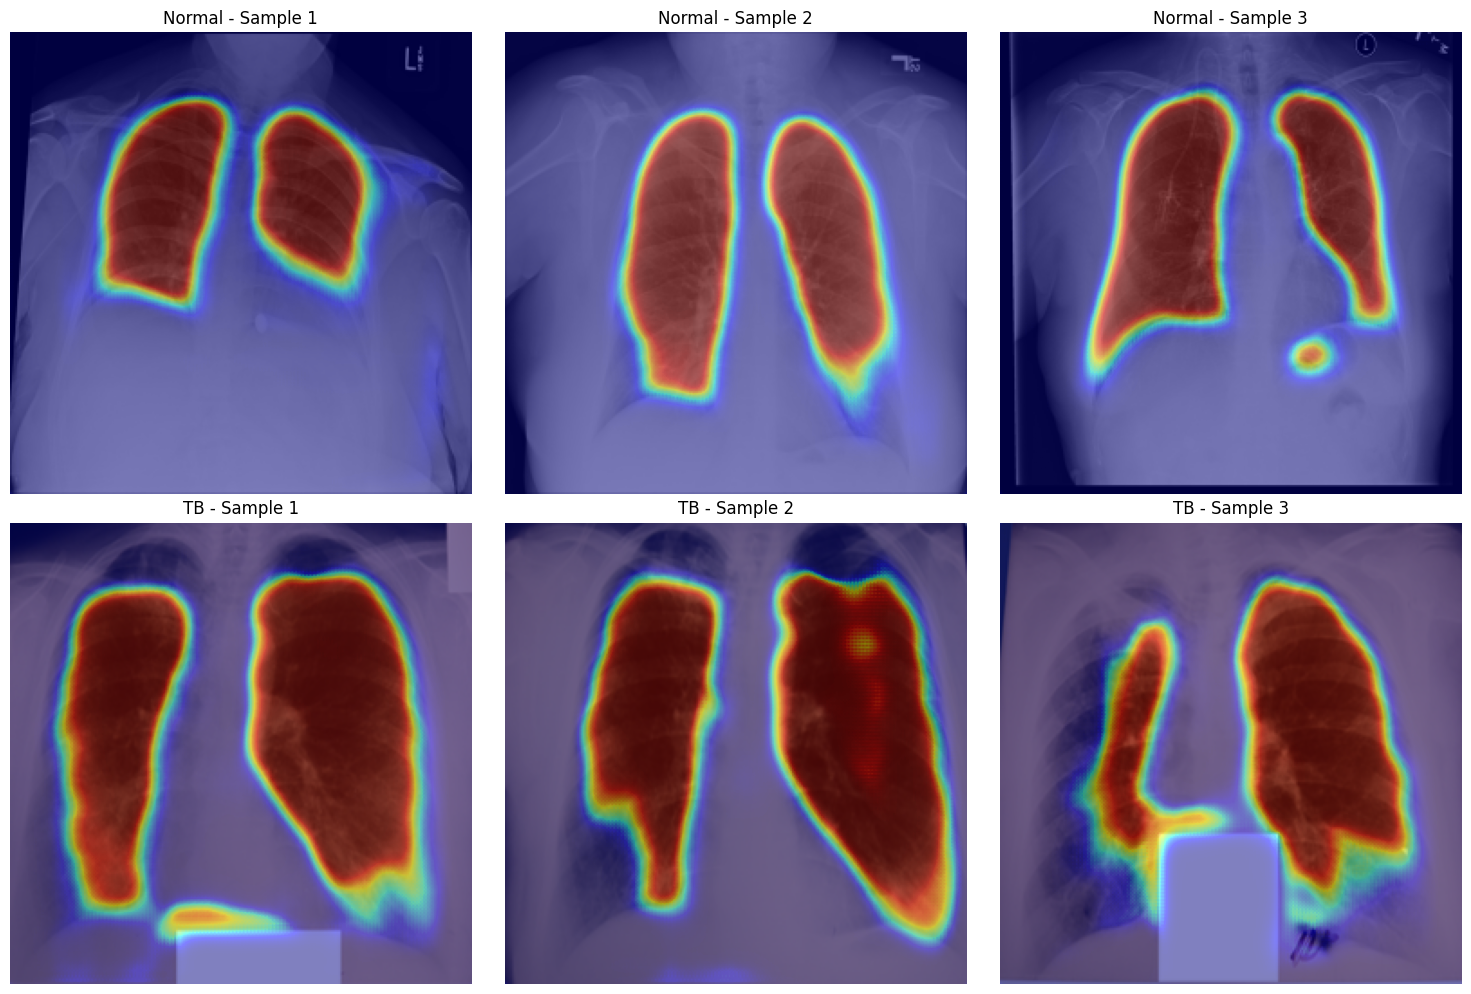

In [18]:
# Load the best U-Net model based on highest validation accuracy
model = tf.keras.models.load_model(f'/kaggle/working/unet_model_fold_3.h5', custom_objects={'dice_coefficient': dice_coefficient})

# Use cleaned_images and labels from preprocessing
all_images = np.array(cleaned_images)  # e.g., (1400, 224, 224, 3)
all_labels = np.array(labels)          # e.g., (1400,)

# Function for segmentation inference
def segment_images(images, model):
    predicted_masks = []
    for img in tqdm(images, desc="Segmentation Inference"):
        # Convert to grayscale if U-Net was trained on grayscale
        img_gray = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])  # RGB to grayscale
        img_expanded = np.expand_dims(img_gray, axis=(0, -1)).astype('float32')
        mask_pred = model.predict(img_expanded, verbose=0)
        predicted_masks.append(mask_pred[0, ..., 0])  # Take first channel
    return np.array(predicted_masks)

# Perform segmentation inference
all_masks = segment_images(all_images, model)

print(f"Segmentation inference completed. Mask array shape: {all_masks.shape}")

# Function to display sample segmentation overlays
def display_segmentation_samples(images, masks, labels, num_samples=3):
    plt.figure(figsize=(15, 10))
    normal_indices = np.where(labels == 0)[0][:num_samples]  # 3 Normal samples
    tb_indices = np.where(labels == 1)[0][:num_samples]      # 3 TB samples
    all_indices = np.concatenate([normal_indices, tb_indices])
    
    for i, idx in enumerate(all_indices):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.imshow(masks[idx], cmap='jet', alpha=0.5)  # Overlay mask with transparency
        plt.title(f"{'Normal' if labels[idx] == 0 else 'TB'} - Sample {i % num_samples + 1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 3 samples from segmentation inference
print("3 Samples from Segmentation Inference:")
display_segmentation_samples(all_images, all_masks, all_labels)

ROI extraction completed. ROI array shape: (1400, 256, 256, 3)
3 Samples from ROI Extraction:


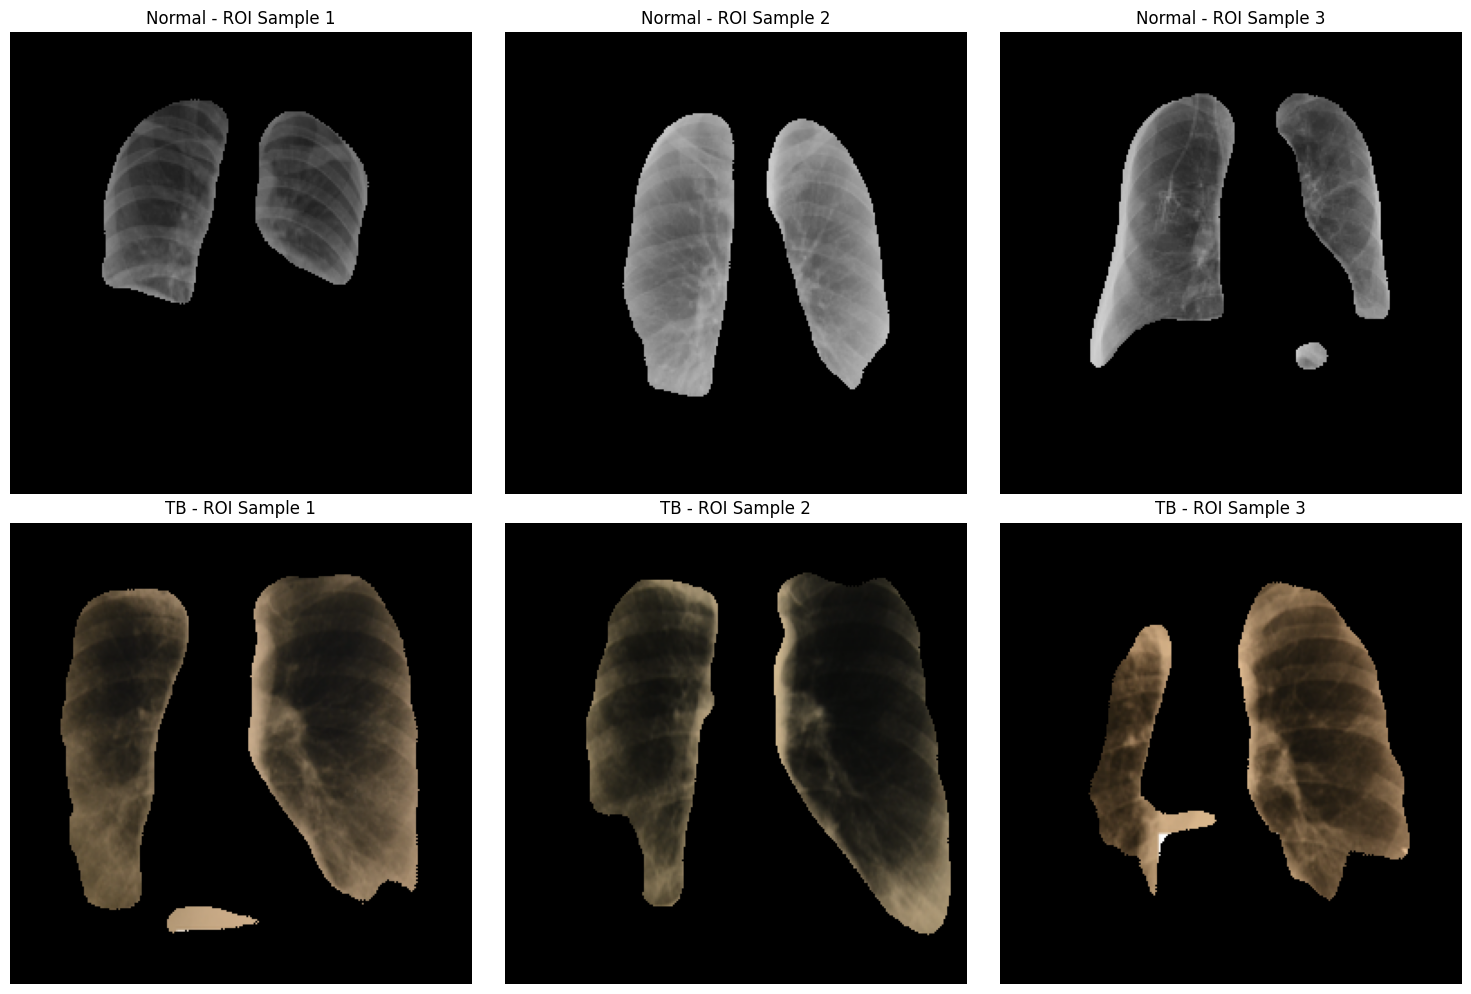

In [19]:
# Function to extract ROI based on mask and threshold (try threshold 0.3, 0.5, 0.7)
def extract_roi(image, mask, threshold=0.5):
    mask_binary = (mask > threshold).astype(np.uint8)
    roi = image * np.stack([mask_binary] * 3, axis=-1)  # Repeat mask for 3 channels
    return roi

# Extract ROI for all images
all_rois = [extract_roi(img, mask) for img, mask in zip(all_images, all_masks)]

# Convert to numpy array
all_rois = np.array(all_rois)

print(f"ROI extraction completed. ROI array shape: {all_rois.shape}")

# Function to display sample ROIs
def display_roi_samples(images, rois, labels, num_samples=3):
    plt.figure(figsize=(15, 10))
    normal_indices = np.where(labels == 0)[0][:num_samples]  # 3 Normal samples
    tb_indices = np.where(labels == 1)[0][:num_samples]      # 3 TB samples
    all_indices = np.concatenate([normal_indices, tb_indices])
    
    for i, idx in enumerate(all_indices):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(rois[idx])
        plt.title(f"{'Normal' if labels[idx] == 0 else 'TB'} - ROI Sample {i % num_samples + 1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 3 ROI samples
print("3 Samples from ROI Extraction:")
display_roi_samples(all_images, all_rois, all_labels)

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming all_images, all_masks, all_rois, all_labels are already defined as numpy arrays
all_images = np.array(all_images)  # (1400, 224, 224, 3)
all_masks = np.array(all_masks)    # (1400, 224, 224)
all_rois = np.array(all_rois)      # (1400, 224, 224, 3)
all_labels = np.array(all_labels)  # (1400,)

# Split data into training set (80%) and temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_rois, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Split temporary set into validation (50% of temp → 10% of total) and test sets (50% of temp → 10% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Verify splits
print(f"Training data count   : {len(X_train)}")
print(f"Validation data count : {len(X_val)}")
print(f"Testing data count    : {len(X_test)}")
print(f"Total data (final)    : {len(X_train) + len(X_val) + len(X_test)}")

# Function to check label distribution
def label_dist(name, y):
    unique, counts = np.unique(y, return_counts=True)
    print(f"Label distribution in {name}: {dict(zip(unique, counts))}")

label_dist("Training", y_train)
label_dist("Validation", y_val)
label_dist("Testing", y_test)

Training data count   : 1120
Validation data count : 140
Testing data count    : 140
Total data (final)    : 1400
Label distribution in Training: {0: 560, 1: 560}
Label distribution in Validation: {0: 70, 1: 70}
Label distribution in Testing: {0: 70, 1: 70}


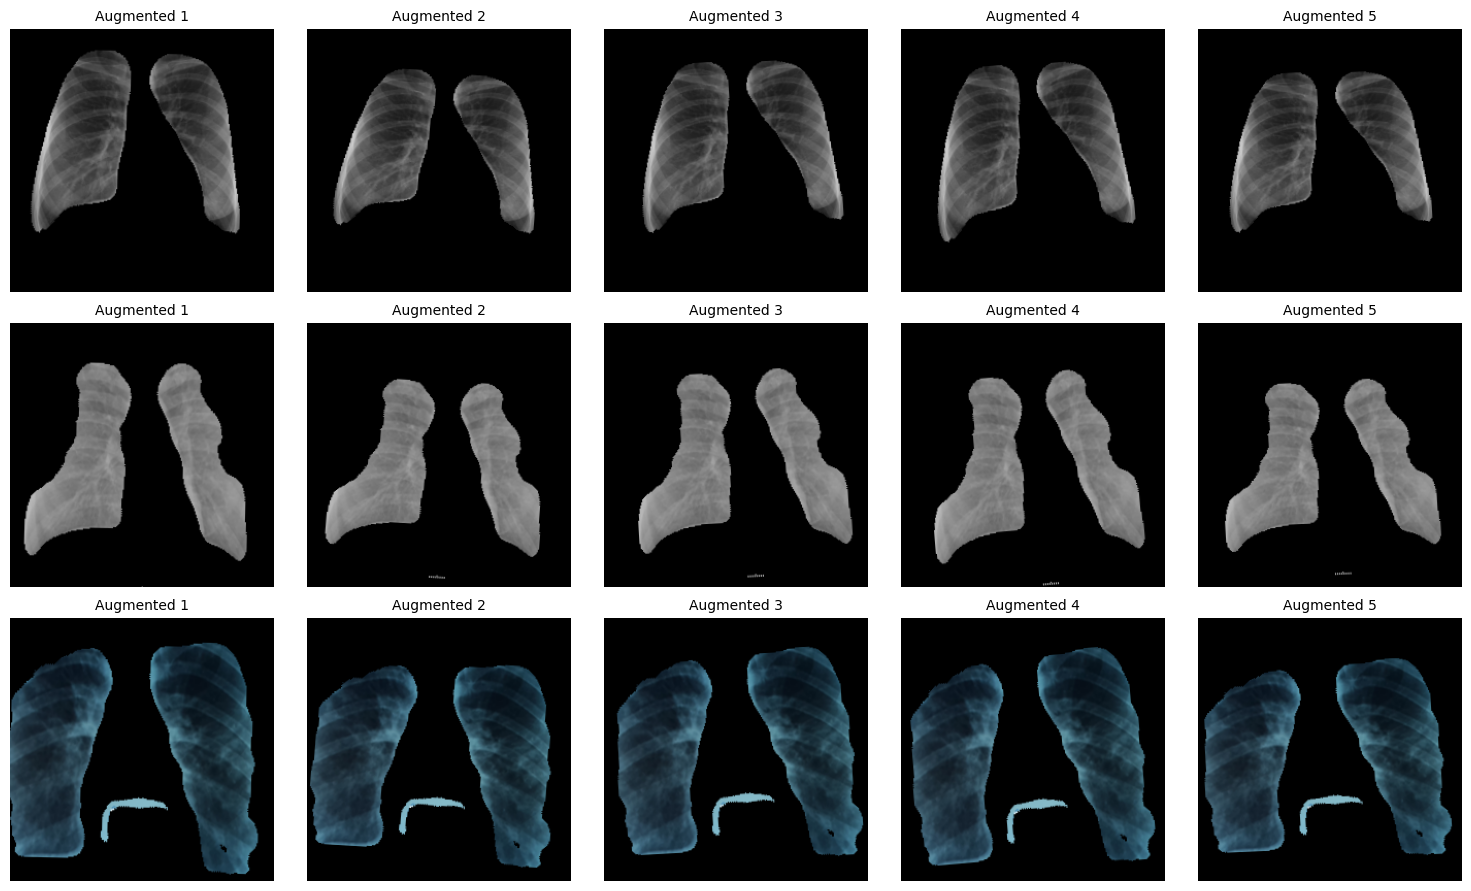

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Data augmentation only for training data
datagenKlas = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # Set True if anatomical side is not critical
    fill_mode='nearest'
)

num_samples = 3      # Number of different training images to display
aug_per_sample = 5   # Number of augmentations per image

plt.figure(figsize=(aug_per_sample * 3, num_samples * 3))

for row in range(num_samples):
    # Take one original image from X_train, scale back to [0,255] uint8
    sample_image = (X_train[row] * 255).astype(np.uint8)
    sample_image = sample_image.reshape((1,) + sample_image.shape)  # Shape: (1, H, W, C)

    gen = datagenKlas.flow(sample_image, batch_size=1, seed=42)

    for col in range(aug_per_sample):
        i = row * aug_per_sample + col + 1
        augmented = next(gen)[0].astype(np.uint8)

        plt.subplot(num_samples, aug_per_sample, i)
        plt.imshow(cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Augmented {col + 1}", fontsize=10)

        if col == 0:
            label_text = 'Normal' if y_train[row] == 0 else 'Positive TB'
            plt.ylabel(f'Sample {row + 1}\n{label_text}', fontsize=12)

plt.tight_layout()
plt.show()


Fold 1/10
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 278ms/step - accuracy: 0.7574 - loss: 0.5674 - val_accuracy: 0.8214 - val_loss: 0.3348
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8454 - loss: 0.3665 - val_accuracy: 0.9018 - val_loss: 0.2389
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9048 - loss: 0.2327 - val_accuracy: 0.8304 - val_loss: 0.3381
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9050 - loss: 0.2474 - val_accuracy: 0.9107 - val_loss: 0.1915
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9414 - loss: 0.1658 - val_accuracy: 0.9643 - val_loss: 0.1048
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9329 - loss: 0.1833 - val_accuracy: 0.9732 - val_loss: 0.1181
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9268 - loss: 0.1956 - val_accuracy: 0.9732 - val_loss: 0.0937
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9288 - loss: 0.1664 - val_accura

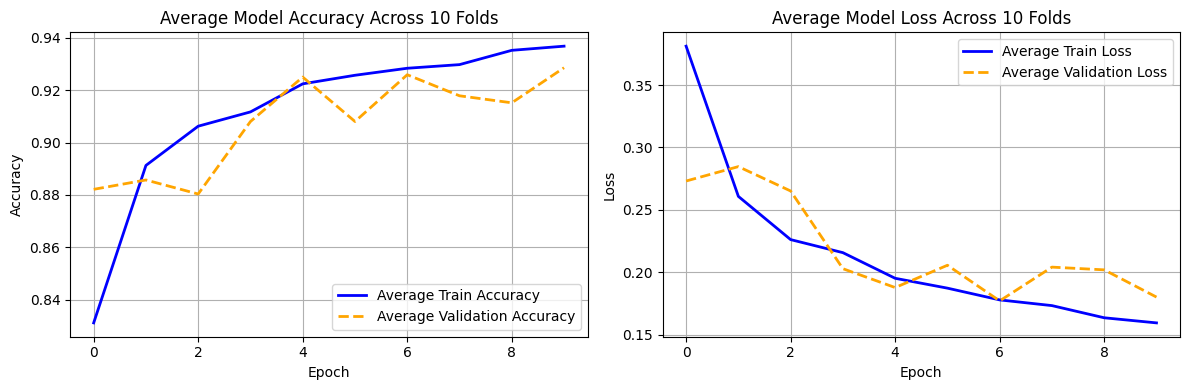

In [22]:
# Function to build DenseNet121 model
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    return model

import cv2

# Initialize parameters
n_splits = 10  # Change to 5 or 3 for further analysis
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_results = []  # Store loss and accuracy per fold
fold_times = []
best_val_acc = -1
best_fold = -1
all_histories = []
total_start_time = time.time()

# K-Fold loop
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train), 1):
    print(f'\nFold {fold}/{n_splits}')
    start_time = time.time()
    
    # Resize images for training and validation in this fold
    X_train_fold = np.array([cv2.resize(img, (224, 224)) for img in X_train[train_idx]])
    y_train_fold = y_train[train_idx]
    X_val_fold = np.array([cv2.resize(img, (224, 224)) for img in X_train[val_idx]])
    y_val_fold = y_train[val_idx]
    
    # Build a new model for each fold
    model = build_model()

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Fit generator for augmentation
    train_generator = datagenKlas.flow(X_train_fold, y_train_fold, batch_size=8)
    
    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train_fold) // 8,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,  # Increase number of epochs
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate on validation data for this fold
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_results.append({'fold': fold, 'val_loss': val_loss, 'val_acc': val_acc})
    
    # Record fold processing time
    fold_time = time.time() - start_time
    fold_times.append(fold_time)
    
    # Save model for this fold
    model.save(f'densenet_model_fold_{fold}.h5')
    
    # Update best fold based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_fold = fold
    
    # Save training history
    all_histories.append(history.history)
    
    print(f'Accuracy Fold {fold}: {val_acc:.4f}, Loss Fold {fold}: {val_loss:.4f}, Time: {fold_time:.2f} seconds')

# Calculate total and average time per fold
total_time = time.time() - total_start_time
avg_fold_time = np.mean(fold_times)

# Handle different epoch lengths to calculate averages
min_epochs = min(len(h['accuracy']) for h in all_histories)
avg_accuracy = np.mean([h['accuracy'][:min_epochs] for h in all_histories], axis=0)
avg_val_accuracy = np.mean([h['val_accuracy'][:min_epochs] for h in all_histories], axis=0)
avg_loss = np.mean([h['loss'][:min_epochs] for h in all_histories], axis=0)
avg_val_loss = np.mean([h['val_loss'][:min_epochs] for h in all_histories], axis=0)

# Print results
print(f"\nTraining with {n_splits}-fold cross-validation completed.")
print(f"Average Accuracy Across Folds: {np.mean([r['val_acc'] for r in fold_results]):.4f} (+/- {np.std([r['val_acc'] for r in fold_results]):.4f})")
print(f"Average Loss Across Folds: {np.mean([r['val_loss'] for r in fold_results]):.4f} (+/- {np.std([r['val_loss'] for r in fold_results]):.4f})")
print(f"Best Fold: Fold {best_fold} with Val Accuracy = {best_val_acc:.4f}")
print(f"Total Processing Time: {total_time:.2f} seconds")
print(f"Average Processing Time per Fold: {avg_fold_time:.2f} seconds")
for i, (result, t) in enumerate(zip(fold_results, fold_times), 1):
    print(f"Fold {i}: Accuracy = {result['val_acc']:.4f}, Loss = {result['val_loss']:.4f}, Time = {t:.2f} seconds")

# Load best model
best_model = tf.keras.models.load_model(f'densenet_model_fold_{best_fold}.h5')
print(f"Successfully loaded best model from densenet_model_fold_{best_fold}.h5")

# Visualize average accuracy and loss
plt.figure(figsize=(12, 4))

# Subplot 1: Average Accuracy
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Train Accuracy', color='blue', linewidth=2)
plt.plot(avg_val_accuracy, label='Average Validation Accuracy', color='orange', linestyle='--', linewidth=2)
plt.title(f'Average Model Accuracy Across {n_splits} Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Subplot 2: Average Loss
plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Train Loss', color='blue', linewidth=2)
plt.plot(avg_val_loss, label='Average Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title(f'Average Model Loss Across {n_splits} Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

X_test shape: (140, 256, 256, 3), dtype: float32
y_test shape: (140,), dtype: int64
Resizing X_test from (256, 256) to (224, 224)
Resized X_test shape: (140, 224, 224, 3)
Successfully loaded best model from densenet_model_fold_1.h5

Test Accuracy: 0.9643
Test Loss: 0.1306

Confusion Matrix:
[[69  1]
 [ 4 66]]

Sensitivity (Recall for Tuberculosis): 0.9429
Specificity: 0.9857

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97        70
Tuberculosis       0.99      0.94      0.96        70

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140



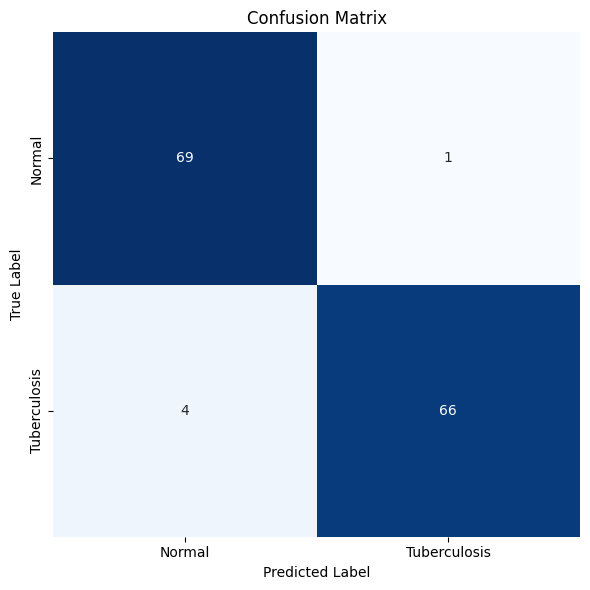

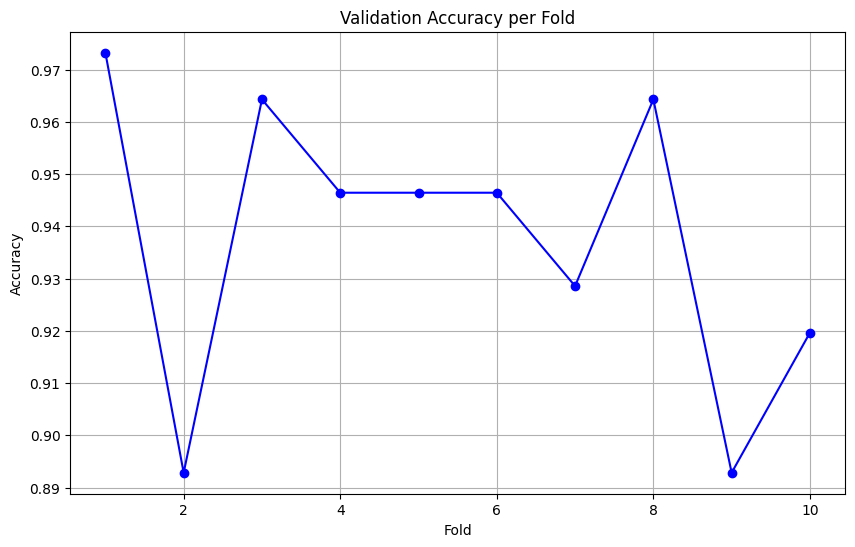


AUC Score: 0.9890


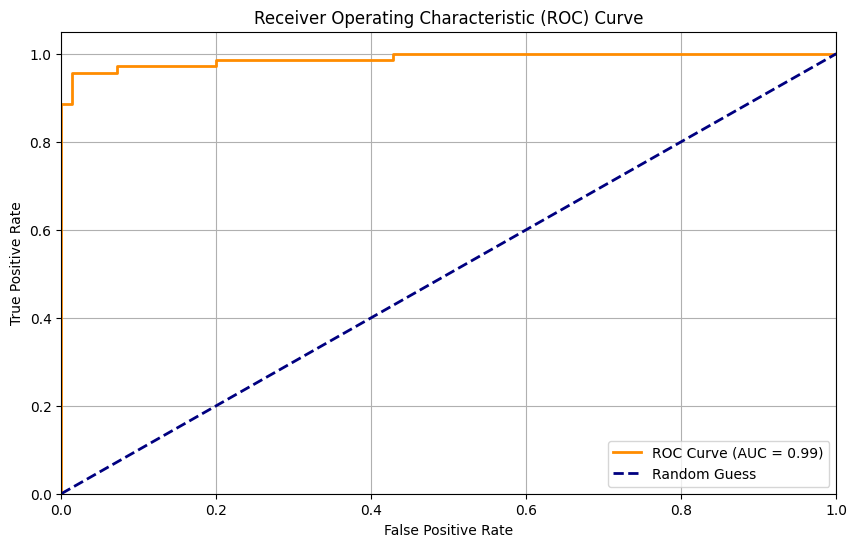

In [23]:
import cv2
import numpy as np

# Verify and convert X_test and y_test to correct format
print(f"X_test shape: {X_test.shape}, dtype: {X_test.dtype}")

# Convert y_test from list to numpy array if needed
if isinstance(y_test, list):
    y_test = np.array(y_test)
    print("y_test converted from list to NumPy array")

# Verify shape and dtype of y_test
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")

# --- Resize X_test to (224, 224, 3) if needed ---
if X_test.shape[1] != 224 or X_test.shape[2] != 224:
    print(f"Resizing X_test from {X_test.shape[1:3]} to (224, 224)")
    X_test_resized = np.zeros((X_test.shape[0], 224, 224, 3), dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test_resized[i] = cv2.resize(X_test[i], (224, 224))
    X_test = X_test_resized
    print(f"Resized X_test shape: {X_test.shape}")

# Ensure X_test is in the correct format: (n_samples, 224, 224, 3), float32, normalized to [0, 1]
if X_test.dtype != np.float32:
    X_test = X_test.astype(np.float32)
    print("X_test converted to float32")
if X_test.max() > 1.0:
    X_test = X_test / 255.0  # Normalize if not already normalized
    print("X_test normalized to [0, 1]")

# Ensure y_test is a 1D binary array
if len(y_test.shape) > 1:
    y_test = y_test.flatten()
    print("y_test flattened to 1D array")
if y_test.dtype not in [np.int32, np.int64]:
    y_test = y_test.astype(np.int32)
    print("y_test converted to int32")

# Verify input shape
expected_shape = (None, 224, 224, 3)
if X_test.shape[1:] != expected_shape[1:]:
    raise ValueError(f"X_test has incorrect shape {X_test.shape}. Expected: {expected_shape}")

# Verify y_test contains only 0 and 1
if not np.all(np.isin(y_test, [0, 1])):
    raise ValueError(f"y_test contains invalid values: {np.unique(y_test)}")

# Load best model based on highest validation accuracy
try:
    model = tf.keras.models.load_model(f'densenet_model_fold_{best_fold}.h5')
    print(f"Successfully loaded best model from densenet_model_fold_{best_fold}.h5")
except NameError:
    raise NameError("Variable 'best_fold' not defined. Run the K-Fold training code first.")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predict probabilities on test data
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Ensure 1D array

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(cm)

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
print(f"\nSensitivity (Recall for Tuberculosis): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Classification Report
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Tuberculosis']))

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Normal', 'Tuberculosis'])
plt.yticks([0.5, 1.5], ['Normal', 'Tuberculosis'])
plt.tight_layout()
plt.show()

# Visualize accuracy per fold (using fold_results from K-Fold training)
try:
    fold_scores = [r['val_acc'] for r in fold_results]  # Extract accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(fold_scores) + 1), fold_scores, marker='o', color='blue')
    plt.title('Validation Accuracy per Fold')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()
except NameError:
    print("fold_results not available. Run the K-Fold training code first to obtain fold_results.")

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'\nAUC Score: {roc_auc:.4f}')

# Visualize ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Successfully loaded best model from densenet_model_fold_1.h5


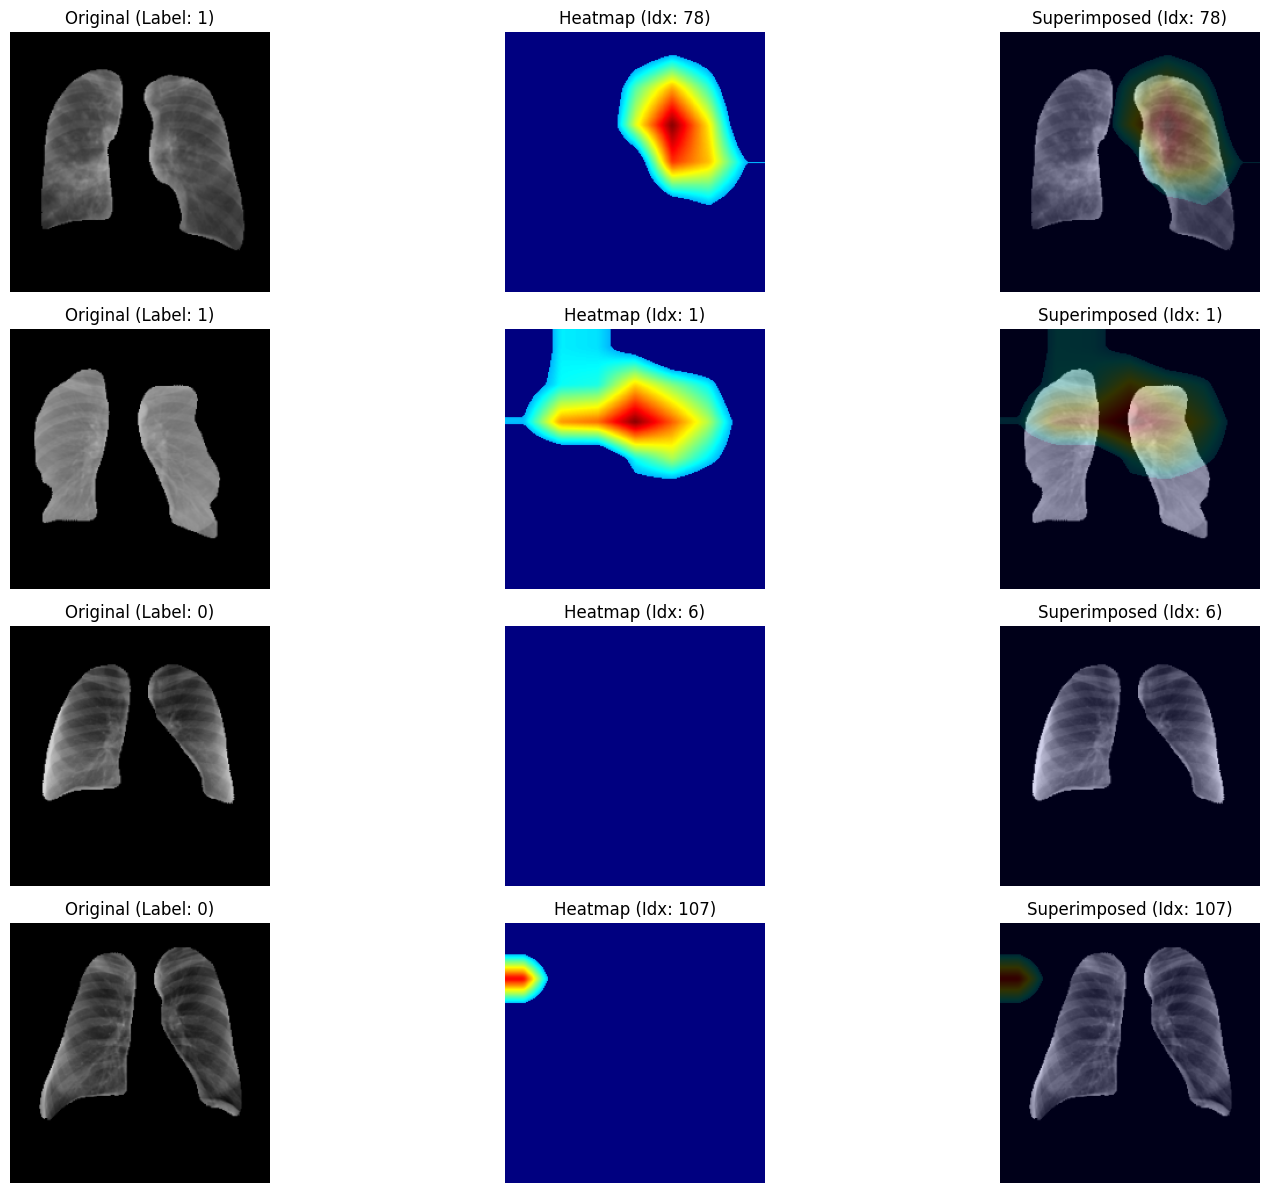

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Index 78, True Label: 1, Predicted Probability: 0.7192, Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Index 1, True Label: 1, Predicted Probability: 0.9590, Predicted Class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Index 6, True Label: 0, Predicted Probability: 0.0003, Predicted Class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Index 107, True Label: 0, Predicted Probability: 0.0091, Predicted Class: 0


In [25]:
# Load the trained model
try:
    model = tf.keras.models.load_model(f'densenet_model_fold_{best_fold}.h5')
    print(f"Successfully loaded best model from densenet_model_fold_{best_fold}.h5")
except NameError:
    raise NameError("Variable 'best_fold' is not defined. Please run the K-Fold training code first.")

# Function to generate Grad-CAM heatmap
def get_gradcam_heatmap(
    model,
    img_array,
    lung_mask=None,
    last_conv_layer_name='conv5_block16_concat',  # more focused & spatially accurate
    colormap=cv2.COLORMAP_JET,
    blur_kernel=(5, 5),  # smoother blur
    threshold=0.3,       # higher to highlight only important areas
    alpha=0.2            # lighter, not covering original image
):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    # Resize and blur
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = cv2.GaussianBlur(heatmap_resized, blur_kernel, 0)

    # Thresholding
    heatmap_resized = np.where(heatmap_resized > threshold, heatmap_resized, 0)

    # Mask with lung segmentation (optional)
    if lung_mask is not None:
        lung_mask_resized = cv2.resize(lung_mask, (224, 224))
        lung_mask_resized = lung_mask_resized / np.max(lung_mask_resized)
        heatmap_resized *= lung_mask_resized

    # Coloring and invert contrast
    heatmap_resized = 1.0 - heatmap_resized
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, colormap)

    return heatmap_colored, heatmap_resized, alpha


# Select samples from X_test by label (e.g., classes 0 and 1)
num_samples = 5
positive_indices = np.where(y_test == 1)[0]
negative_indices = np.where(y_test == 0)[0]
sample_indices = np.concatenate([
    np.random.choice(positive_indices, min(num_samples // 2, len(positive_indices)), replace=False),
    np.random.choice(negative_indices, min(num_samples // 2, len(negative_indices)), replace=False)
])
sample_indices = sample_indices[:num_samples]

# Output directory
output_dir = 'results/gradcam_results'
os.makedirs(output_dir, exist_ok=True)

# Visualize Grad-CAM for selected samples
plt.figure(figsize=(15, 3 * num_samples))

for i, idx in enumerate(sample_indices):
    img = X_test[idx]
    img_label = y_test[idx]
    img_array = np.expand_dims(img, axis=0)

    heatmap_colored, heatmap_resized, alpha = get_gradcam_heatmap(model, img_array)

    # Superimpose heatmap on original image
    superimposed_img = heatmap_colored * alpha + np.uint8(255 * img)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Plot results
    plt.subplot(num_samples, 3, 3 * i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original (Label: {img_label})')
    plt.axis('off')

    plt.subplot(num_samples, 3, 3 * i + 2)
    plt.imshow(heatmap_colored)
    plt.title(f'Heatmap (Idx: {idx})')
    plt.axis('off')

    plt.subplot(num_samples, 3, 3 * i + 3)
    plt.imshow(superimposed_img)
    plt.title(f'Superimposed (Idx: {idx})')
    plt.axis('off')

    # Save images
    filename = f'sample_{idx}.png'
    cv2.imwrite(os.path.join(output_dir, f'original_{filename}'),
                cv2.cvtColor(np.uint8(255 * img), cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(output_dir, f'heatmap_{filename}'),
                cv2.cvtColor(heatmap_colored, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(output_dir, f'superimposed_{filename}'),
                cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

plt.tight_layout()
plt.show()

# Prediction for verification
for idx in sample_indices:
    img = X_test[idx][np.newaxis, ...]
    pred = model.predict(img)
    predicted_class = 1 if pred[0][0] > 0.5 else 0
    print(f'Index {idx}, True Label: {y_test[idx]}, Predicted Probability: {pred[0][0]:.4f}, Predicted Class: {predicted_class}')


In [27]:
model.save('tb.h5')

In [32]:
model.save('tb.h5')

import tensorflow as tf
import os

# 1. Load your Keras model
model = tf.keras.models.load_model('tb.h5')  # Replace 'your_model.h5' with your file path

# 2. Initialize the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 3. Enable optimization (e.g., default optimizations)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 4. Convert the model
tflite_model = converter.convert()

# 5. Save the .tflite file
tflite_file_path = "tb.tflite" 
with open(tflite_file_path, 'wb') as f:
    f.write(tflite_model)

# 6. Get the size of the .tflite file in MB
tflite_file_size = os.path.getsize(tflite_file_path)
tflite_file_size_mb = tflite_file_size / (1024 * 1024)

# 7. Print the size
print(f"The size of {tflite_file_path} is: {tflite_file_size_mb:.2f} MB")

Saved artifact at '/tmp/tmpov0kxaie'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139798952491920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952490960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952490576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952490768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952492496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952489808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952489424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952491344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952490192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139798952487888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1397989524875

W0000 00:00:1755160446.259619      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1755160446.259670      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


The size of tb.tflite is: 7.19 MB
